# Some simple Machine Learning algorithm implimentations in Python

During my 3rd year Machine Learning course, I built this notebook in order to better familiarise myself with how some of the basic machine learning algorithms worked and could be implimented, and to allow myself to play around with them a bit.

# Preparation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.cross_validation import train_test_split
import pylab as pl
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import scale
import cvxopt
from cvxopt import solvers

### Data and Plotting

In [3]:
N = 40
# Two 2-d Normal datasets
mean1 = [-1, 2]
mean2 = [1, -1]
mean3 = [4, -4]
mean4 = [-4, 4]
covar = [[1.0,0.8], [0.8, 1.0]]
X1 = np.random.multivariate_normal(mean1, covar, 50)
X1 = np.vstack((X1, np.random.multivariate_normal(mean3, covar, 50)))
y1 = np.ones(len(X1))
X2 = np.random.multivariate_normal(mean2, covar, 50)
X2 = np.vstack((X2, np.random.multivariate_normal(mean4, covar, 50)))
y2 = np.ones(len(X2)) * -1

# Concatenate for full dataset
X = concatenate((X1, X2))
y = concatenate((y1, y2))

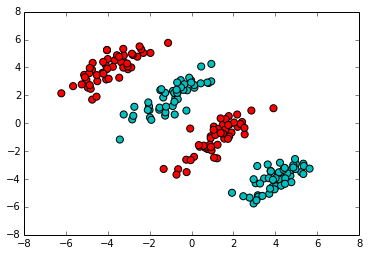

In [4]:
scatter(X[:,0], X[:,1], c=['r' if yy < 0 else 'c' for yy in y], s=50)

In [5]:
class Tester():
    '''Class for plotting example classification results'''
    
    def __init__(self, X, y):
        # Split data in to test/train segments
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X = X
        self.y = y
        
    def get(self):
        return (self.X_test, self.X_train, self.y_test, self.y_train)
        
    def predict(self, predictor):
        return predictor.fit(self.X_train, self.y_train).predict(self.X_test)
        
    def __call__(self, predictor):
        h=0.08
        # Predict class of all values on a grid
        x_min, x_max = self.X[:, 0].min() - 3.5, self.X[:, 0].max() + 3.5
        y_min, y_max = self.X[:, 1].min() - 3.5, self.X[:, 1].max() + 3.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = np.c_[xx.ravel(), yy.ravel()]
        
        # Call the fit()/predict() methods
        Z = predictor.fit(self.X_train, self.y_train).predict(Z)
        
        # Contour plot the prediction
        Z = Z.reshape(xx.shape)
        cm = pl.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        contourf(xx, yy, Z, cmap=cm)
        
        # Scatter plot the test/train values
        scatter(self.X_train[:, 0], self.X_train[:, 1], c=self.y_train, cmap=cm_bright)
        scatter(self.X_test[:, 0], self.X_test[:, 1], marker='x', c=self.y_test, cmap=cm_bright,alpha=0.6)

        score = sum(predictor.predict(self.X_test) == self.y_test)
        print "Accuracy: ", float(score)/len(self.X_test)
        
test = Tester(X, y)

# Basic Kernels

In [6]:
class NoTransform():
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X
    
class BiasTransform():
    def fit(self, X, y=None):
        self.R = sqrt(max((sum((X - mean(X, axis=0))**2, axis=1))))
        return self
    
    def transform(self, X):
        # Add a dummy input variable to every observation
        return np.column_stack((X, self.R*ones(X.shape[0])))

class RadialKMeansTransform():
    def __init__(self, k=None):
        self.def_k = k
    def fit(self, X, y=None):
        if self.def_k:
            k = self.def_k
        else:
            k = len(set(list(y)))
        self.clusters = KMeans(k).fit(X).means

        return self
    def transform(self, X):
        return exp(-vstack([sum((X-m)**2, axis=1) for m in self.clusters]).T)
    

# KNN

Classify new points by assigning them the class most common to K nearby training points

Accuracy:  1.0


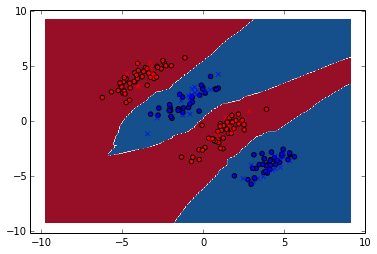

In [7]:
class KNN():
    def __init__(self, k=5):
        # Set the K of KNN
        self.k = k
    
    def fit(self, X, y):
        # Just store the training data
        self.X_train = X
        self.y_train = y
        return self
        
    def predict(self, X):
        def pred(x):
            # Get distance of the point to each training point
            dists = sqrt(sum((self.X_train - x)**2, axis=1))
            
            # Get a list of the classes of the K closest points
            ns = list(self.y_train[argsort(dists)[:self.k]])
            
            # Return the most common point
            return max(set(ns), key=ns.count)
        
        return apply_along_axis(pred, 1, X)
    
figure()
test(KNN(5))


# Perceptron

Loop over the training points and continuously update the weightings on a linear surface (or line) which should converge to a solution in the case of linearly separable data.

Classify new points by the side of the line/hyperplane they lie. 

499 iterations, 50 errors
49
Accuracy:  0.72


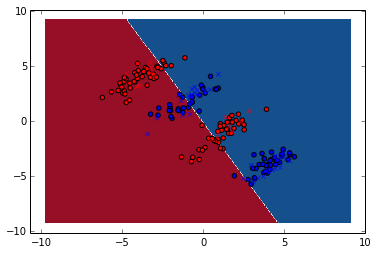

In [8]:
class Perceptron():
    def __init__(self, kernel='linear', k=None):
        if kernel == 'linear':
            self.kernel = BiasTransform()
        elif kernel == 'kmeans':
            self.kernel = RadialKMeansTransform(k)
            
    def fit(self, X, y):
        # Kernal transformation of X
        perm = permutation(range(len(X)))
        X = X[perm]
        y = y[perm]
        self.kernel = self.kernel.fit(X, y)
        dX = self.kernel.transform(X)

        # Vector of weights
        # number of weights = number of basis functions
        w = zeros(dX.shape[1])
        
        # Store best weights/score
        best_w = w
        best_score = len(dX)

        # Repeat algorithm 100 times
        for rep in range(500):
            # Loop through observations
            for xk, yk in zip(dX, y):
                # If the observation is misclassified
                if yk * dot(xk, w) <= 0:
                    # Add its vector to the weights
                    w += yk*xk
            
            # Calculate number of errors
            score = sum(y*dot(dX, w)<0)
            
            # Store weights if they score better than the previous
            # best
            if score < best_score:
                best_score = score
                best_w = w
                
            # Finish if there are no errors
            if score == 0:
                break
        print "{} iterations, {} errors".format(rep, score)

        self.w = best_w
        print best_score
        return self
    def predict(self, X):
        X = self.kernel.transform(X)
        return array(((dot(X, self.w)) > 0)*2-1)
        
figure()
perp = Perceptron(kernel='linear', k=4)
test(perp)


Note that the perceptron is incapable of splitting this dataset.

# K-Means Clustering

Starting with K random 'centroid' positions, assign training points to be members of the closest centroid. Update the positions of each centroid to be the mean position of its members, then repeat until convergence. The algorithm should produce K clusters. New data is classified according to the closest cluster.

Accuracy:  0.0


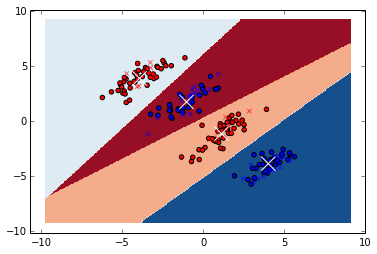

In [9]:
class KMeans():
    def __init__(self, k):
        self.k = k
            
    def fit(self, X, y=None):
        k = self.k
        # Assign points to K random groups of roughly equal sizes
        group = zeros(len(X))
        
        new_group = permutation(concatenate([i*ones(l) for i, l in enumerate([len(l) for l in array_split(X, k)])]))
        
        # Do until no change
        while not array_equal(new_group, group):
            group = new_group
            # Calculate the new cluster means
            means = array([mean(X[group==i], axis=0) for i in range(k)])
            # Re-assign each point to the closest cluster
            new_group = argmax(vstack([-sum((X-m)**2, axis=1) for m in means]).T, axis=1)                
        
        self.means = means
        return self
    
    def predict(self, X):
        # For each point, return the index of the closest cluster
        return argmax(vstack([-sum((X-m)**2, axis=1) for m in self.means]).T, axis=1)

km = KMeans(4)
test(km)
scatter(km.means[:,0],km.means[:,1], marker='x', s=200, c='w')

# SVM

Using quadratic optimisation techniques, find the hyperplane (or line) which will split the training data linearly with largest possible margin between the boundary and the training data. For data which is not linearly separable, map the data to a higher-dimensional space (using a 'kernel function') where the data will be separable.

The training data points closest to the margins are called the 'support vectors'. Classify new data points based on their positions relative to the support vectors.

Accuracy:  0.98
Accuracy:  1.0


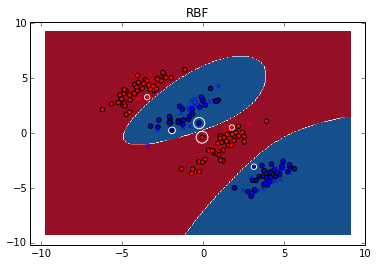

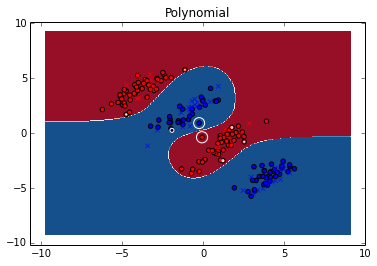

In [10]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)
 
def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p
 
def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2.0 / (2.0 * (sigma ** 2.0)))

class SVM():
    def __init__(self, C=None, kernel=gaussian_kernel):
        self.kernel = kernel
        self.C = C
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = array(y, dtype=float)
        # Because this is a minimisation problem instead
        # of a maximisation problem, components of the
        # lagrangian are multiplied by -1

        
        # Build P, an NxN matrix of
        # y_n * y_m * k(x_n, x_m) for all combinations of x
        # where k is the kernel function (dot product)
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                # Dot product of training samples
                K[i,j] = self.kernel(X[i], X[j])
        P = cvxopt.matrix(outer(y,y) * K)
        
        # coefficient of a_n is -1
        q = cvxopt.matrix(ones(n_samples) * -1)
        
        # Equality constraint: A*a = 0
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        
        # Inequality constraint
        if self.C is None:
            # Hard margin, G*a > h
            #              1*a > 0
            G = cvxopt.matrix(diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(zeros(n_samples))
        else:
            # Soft margin, C > a > 0
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
            
        solvers.options['show_progress']= False
                
        # Solve QP problem
        solution = solvers.qp(P, q, G, h, A, b)
        
        # Solution gives the lagrange multipliers
        a = np.ravel(solution['x'])
        
        # The only interesting ones are > 0
        sv = a>1e-5
        ind = np.arange(len(a))[sv]
        
        # Get X and y of interesting support vectors
        self.sv_x = X[sv]
        self.sv_y = y[sv]
        self.a = a[sv]
        
        # Calculate intercept:
        # sum of:
        #     target - sum of: support vectors * target * k(x, m)
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)
        
        return self
    
    def predict(self, X):
        y_predict = np.zeros(len(X))
        # Loop through each observation i
        for i in range(len(X)):
            # Decision variable s=y(x)
            s = 0
            # Loop through each support vec n
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv_x):
                # Add the vectorweight * classn * kernel(x_i, vec_n)
                s += a * sv_y * self.kernel(X[i], sv)
                
            y_predict[i] = s
        
        # Classification determined by sign of decision variable
        return sign(y_predict + self.b)

figure()
svm = SVM(C=10000, kernel=gaussian_kernel)
test(svm)
title('RBF')
scatter(svm.sv_x[:,0], svm.sv_x[:,1], 
        edgecolors='w', facecolors='none', s=(scale(svm.a)-min(scale(svm.a)))*50)

figure()
svm = SVM(C=100, kernel=polynomial_kernel)

test(svm)

scatter(svm.sv_x[:,0], svm.sv_x[:,1], 
        edgecolors='w', facecolors='none', s=(scale(svm.a)-min(scale(svm.a)))*50)
title('Polynomial')